In [1]:
import  cv2
import numpy as np
from keras.models import load_model, Sequential, Model
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, TimeDistributed, LSTM

from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

#For local CPU usage:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#face detection and extraction
from mtcnn.mtcnn import MTCNN
from PIL import Image
from numpy import asarray

from datetime import datetime
import dlib
from matplotlib import pyplot as plt

Using TensorFlow backend.
c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\tobias\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [2]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

EMOTION_DICT = {1:"ANGRY", 2:"DISGUST", 3:"FEAR", 4:"HAPPY", 5:"NEUTRAL", 6:"SAD", 7:"SURPRISE"}

LSTM_layer = False
W_LANDMARKS = True

p = "shape_predictor_68_face_landmarks.dat"
dlib_predictor = dlib.shape_predictor(p) 

### Define functions and model from training, necessary for prediction

In [3]:
detector = MTCNN()

def detect_faces(image):
    faces = detector.detect_faces(image)
    return np.array(faces)

In [4]:
def extract_face_from_image(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_faces(image) # content of face is a python dict

    
    print(len(face))
    print(face)
    
    if len(face) == 0:
        return []
    else:
        box = np.asarray(face[0].get("box", ""))
        print(box) 
    
        box[box < 0] = 0
        x1, y1, width, height =  box
        x2, y2 = x1 + width, y1 + height
        
        rect = dlib.rectangle(left=x1, top=y1, right=x2, bottom=y2)
        landmarks = dlib_predictor(image, rect)

        for n in range(0,68):
            x=landmarks.part(n).x
            y=landmarks.part(n).y
            cv2.circle(image, (x, y), 4, (0, 0, 255), -1)  # image, cord (x, y), radius 4, color (0, 0, 255), thickness -1

        # extract the face
        face_boundary = image[y1:y2, x1:x2]
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        out = asarray(face_image)
        return out   

In [5]:
def get_bounding_box(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_faces(image) # content of face is a python dict
    
    if len(face) == 0:
        return []
    elif len(face) == 1:
        # extract the bounding box from the requested face
        box = np.asarray(face[0]['box'])
        box[box < 0] = 0
        return np.array(box)
    else:
        box = []
        for elem in face:
            b = np.asarray(elem['box'])
            b[b < 0] = 0
            box.append(b)
        return np.array(box)

In [6]:
def custom_vgg_model():
    if LSTM_layer == True:
        model_VGGFace = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        
        model = Sequential()
        model.add(TimeDistributed(model_VGGFace, input_shape=(5, 224, 224, 3)))
        model.add(TimeDistributed(Flatten(), name='flatten'))
        model.add(LSTM(256, activation='relu', return_sequences=False, name='lstm'))
        model.add(Dropout(0.7, name='dropout'))
        model.add(Dense(1024, activation='relu', name='dense'))
        model.add(Dropout(0.6, name='dropout2'))
        model.add(BatchNormalization(name='batchNorm'))
        model.add(Dense(2, activation='tanh', name='out'))
        return model
        
    else:
        model_VGGFace = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        last_layer = model_VGGFace.get_layer('avg_pool').output    
        print(last_layer.shape)

        x = Flatten(name='flatten')(last_layer)
        x = Dropout(0.7)(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.6)(x)
        x = BatchNormalization()(x)

        out1 = Dense(1, activation='tanh', name='out1')(x)
        out2 = Dense(1, activation='tanh', name='out2')(x)

        custom_vgg_model = Model(inputs= model_VGGFace.input, outputs= [out1, out2])
        return custom_vgg_model

In [13]:
model = custom_vgg_model()

if LSTM_layer == True:
    for layer in model.layers:
        if hasattr(layer, 'layer') and layer.layer.name == 'vggface_resnet50':
            print(layer.layer.name)
            layer.layer.load_weights("model_checkpoints/lstm/VGGFace.h5")
        elif layer.name == 'flatten' or layer.name == 'dropout' or layer.name == 'dropout2':
            print("Not set: " + layer.name)
        else:
            print(layer.name)
            weights = np.load("model_checkpoints/lstm/weights_" + str(layer.name) + ".npy", allow_pickle=True)
            layer.set_weights(weights)
else:
    model.load_weights("model_checkpoints/model_best_v26.h5")
    
model.summary()

(?, 1, 1, 2048)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_6[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________

__________________________________________________________________________________________________


### Create the application

In [14]:
def return_prediction(path):
    #converting image to RGB color and save it
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    #detect face in image, crop it then resize it
    face = extract_face_from_image(img)
    
    if face.ndim == 3:
        face = face.reshape((1, face.shape[0], face.shape[1], face.shape[2]))
    
    #make prediction and display the result
    top_pred = model.predict(face)
    print(top_pred)

    val = top_pred[0][0][0]
    ar = top_pred[1][0][0]
    print("result: " + str(val) + ", " + str(ar))
    return val, ar

In [15]:
## ## face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

cap = cv2.VideoCapture(0)

def run_app(text, cap):
    while(True):
        ret, img = cap.read()
        img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(text), (95,30), font, 0.7, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(img, "Press SPACE: FOR EMOTION", (5,470), font, 0.7, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(img, "Hold Q: To Quit", (460,470), font, 0.7, (255, 0, 0), 2, cv2.LINE_AA)
        
        
        box = get_bounding_box(img_color)
        if box == []:
            print("No bounding box")
        elif box.ndim == 1:
            x,y,w,h = box
            cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
            cv2.imshow("Emotion Recognition - MasterThesis", img)
        elif box.ndim >= 2:
            for elem in box:
                x, y, w, h = elem
                cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
            cv2.imshow("Emotion Recognition - MasterThesis", img)
        
        if cv2.waitKey(1) == ord(' '):
            now = datetime.now()
            cv2.imwrite("test.jpg", img)
            valence, arousal = return_prediction("test.jpg")
            
            later = datetime.now()
            seconds = later - now
            print("Duration: " + str(seconds))
            run_app("Valence: " + str(valence) + ", Arousal: " + str(arousal) , cap)
            # run_app("No Emotion", cap)
            break
            
        if cv2.waitKey(1) == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

1
[{'box': [272, 82, 197, 264], 'confidence': 0.99998939037323, 'keypoints': {'left_eye': (318, 188), 'right_eye': (409, 187), 'nose': (357, 259), 'mouth_left': (325, 280), 'mouth_right': (410, 278)}}]
[272  82 197 264]


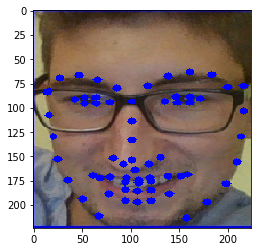

In [16]:
img = cv2.cvtColor(cv2.imread("test.jpg"), cv2.COLOR_BGR2RGB)
face = extract_face_from_image(img)
plt.imshow(face)

In [17]:
run_app("None", cap)

C:\Users\Tobias\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1
[{'box': [253, 87, 207, 273], 'confidence': 0.9999912977218628, 'keypoints': {'left_eye': (308, 191), 'right_eye': (402, 202), 'nose': (348, 264), 'mouth_left': (305, 296), 'mouth_right': (383, 304)}}]
[253  87 207 273]
[array([[-0.05104946]], dtype=float32), array([[0.16067216]], dtype=float32)]
result: -0.05104946, 0.16067216
Duration: 0:00:02.032000
1
[{'box': [255, 100, 214, 285], 'confidence': 0.9999793767929077, 'keypoints': {'left_eye': (315, 195), 'right_eye': (412, 214), 'nose': (347, 277), 'mouth_left': (302, 313), 'mouth_right': (376, 328)}}]
[255 100 214 285]
[array([[-0.02782756]], dtype=float32), array([[0.04028613]], dtype=float32)]
result: -0.02782756, 0.04028613
Duration: 0:00:00.705998
1
[{'box': [264, 117, 193, 236], 'confidence': 0.9999449253082275, 'keypoints': {'left_eye': (319, 194), 'right_eye': (405, 208), 'nose': (349, 261), 'mouth_left': (310, 295), 'mouth_right': (377, 306)}}]
[264 117 193 236]
[array([[-0.02499675]], dtype=float32), array([[0.12925892]], 

1
[{'box': [344, 158, 222, 292], 'confidence': 0.9947898387908936, 'keypoints': {'left_eye': (400, 266), 'right_eye': (490, 300), 'nose': (413, 350), 'mouth_left': (374, 368), 'mouth_right': (451, 394)}}]
[344 158 222 292]
[array([[0.1503304]], dtype=float32), array([[0.16275357]], dtype=float32)]
result: 0.1503304, 0.16275357
Duration: 0:00:00.691000
1
[{'box': [345, 162, 220, 291], 'confidence': 0.9976104497909546, 'keypoints': {'left_eye': (404, 263), 'right_eye': (487, 305), 'nose': (405, 353), 'mouth_left': (367, 373), 'mouth_right': (440, 404)}}]
[345 162 220 291]
[array([[0.11610353]], dtype=float32), array([[0.19402456]], dtype=float32)]
result: 0.11610353, 0.19402456
Duration: 0:00:00.697995
1
[{'box': [346, 206, 212, 245], 'confidence': 0.9639186263084412, 'keypoints': {'left_eye': (409, 287), 'right_eye': (481, 308), 'nose': (412, 363), 'mouth_left': (390, 384), 'mouth_right': (452, 402)}}]
[346 206 212 245]
[array([[0.05232235]], dtype=float32), array([[0.06980996]], dtype=